Classificatore KNN in SKlearn
L'implementazione del classificatore KNN in SKlearn può essere eseguita facilmente con l'aiuto del modulo KNeighborsClassifier(). In questo esempio, useremo un set di dati di giocatori per classificare come ala, guardia, play, centro in base alle statistiche e all'altezza con il classificatore KNN in Sklearn.

 Importazione delle librerie necessarie

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

Importo il set di dati dei giocatori

In [2]:
giocatori = pd.read_csv('..\dataset\giocatori.csv')

Controlla quanti record ci sono per le etichette di classe Play, Guardia, Ala, Centro. Possiamo vedere che è un set di dati abbastanza equilibrato.

In [3]:
giocatori.info()
giocatori['ruolo'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   nome_giocatore    249 non-null    object 
 1   numero_giocatore  234 non-null    float64
 2   squadra           249 non-null    object 
 3   ruolo             210 non-null    object 
 4   altezza           249 non-null    int64  
 5   minuti            249 non-null    float64
 6   falli_c           249 non-null    float64
 7   falli_s           249 non-null    float64
 8   t2_r              249 non-null    float64
 9   t2_t              249 non-null    float64
 10  t2_per            249 non-null    float64
 11  t3_r              249 non-null    float64
 12  t3_t              249 non-null    float64
 13  t3_per            249 non-null    float64
 14  t1_r              249 non-null    float64
 15  t1_t              249 non-null    float64
 16  t1_per            249 non-null    float64
 1

Ala        69
Guardia    54
Play       49
Centro     38
Name: ruolo, dtype: int64

Droppo le colonne che sicuramente non influiranno sulla predizione del ruolo, ma mantengo i minuti per utilizzarli come fattore di normalizzazione sulle altre colonne

In [4]:
giocatori = giocatori.drop('nome_giocatore', axis = 1)
giocatori = giocatori.drop('numero_giocatore', axis = 1)
giocatori = giocatori.drop('squadra', axis = 1)
giocatori = giocatori.drop('rim_d', axis = 1)
giocatori = giocatori.drop('rim_o', axis = 1)
giocatori = giocatori.drop('t1_per', axis = 1)
giocatori = giocatori.drop('t2_per', axis = 1)
giocatori = giocatori.drop('t3_per', axis = 1)
giocatori = giocatori.dropna();

In [5]:
import numpy as np

# Definire una funzione per scalare i valori di ogni riga
def scale_cols(df, col):
    df = df[df[col] != 0]
    factor = (40/df[col].values)
    float_cols = df.select_dtypes(include=['float64']).columns
    float_cols = float_cols.drop(col)
    df[float_cols] = df[float_cols].mul(factor, axis=0)
    return df

giocatori = scale_cols(giocatori, 'minuti')

print(giocatori)

       ruolo  altezza  minuti    falli_c   falli_s      t2_r       t2_t  \
0        Ala      198     7.5  10.666667  0.000000  0.000000   5.333333   
1    Guardia      193    30.6   3.660131  5.359477  5.098039   9.542484   
2        Ala      208    23.0   4.869565  7.304348  4.173913   8.347826   
3        Ala      203    15.3   3.398693  1.307190  2.875817   5.490196   
4        Ala      200     8.4   3.809524  1.904762  1.428571   6.190476   
..       ...      ...     ...        ...       ...       ...        ...   
242      Ala      196    26.8   4.179104  1.791045  1.343284   3.731343   
243     Play      184    20.5   5.463415  2.536585  2.926829  10.341463   
244     Play      188    22.8   3.859649  3.157895  1.929825   3.684211   
246      Ala      208    11.1   5.045045  1.441441  3.243243   6.486486   
247      Ala      205    19.0   5.473684  1.052632  1.894737   2.736842   

         t3_r      t3_t      t1_r      t1_t     rim_t    stop_d    stop_s  \
0    0.000000  5.33333

C:\Users\nicol\AppData\Local\Temp\ipykernel_21056\387332450.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[float_cols] = df[float_cols].mul(factor, axis=0)


rimuovo i restanti campi inutili

In [6]:
giocatori = giocatori.drop('minuti', axis = 1)

Analisi esplorativa dei dati
Dopo aver caricato il set di dati, eseguiremo alcune analisi esplorative dei dati per comprendere meglio i nostri dati.

Per prima cosa visualizziamo la correlazione tra le diverse caratteristiche presenti nel nostro set di dati. Quindi, useremo un grafico a linee per comprendere le caratteristiche fortemente (positivamente) correlate e le caratteristiche correlate negativamente.

C:\Users\nicol\AppData\Local\Temp\ipykernel_21056\730944499.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  player_correlation = giocatori.corr()


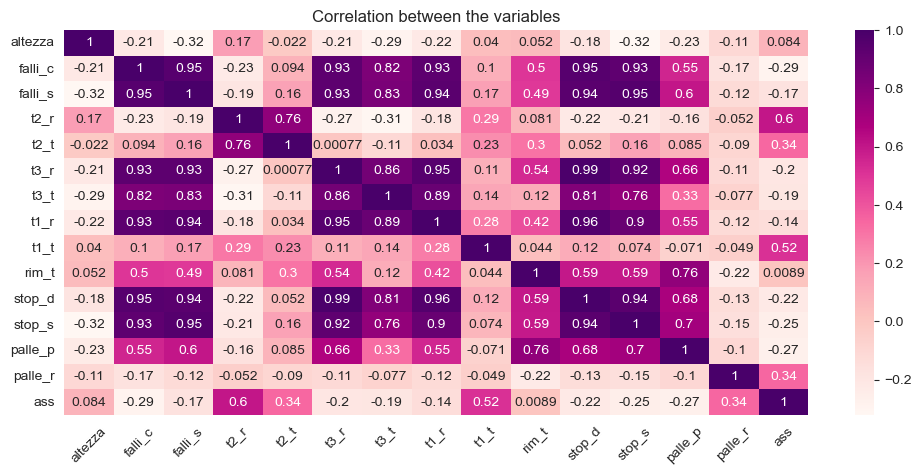

In [7]:
#Analisi esplorativa dei dati
#correlation matrix and the heatmap
plt.subplots(figsize=(12,5))
player_correlation = giocatori.corr()
sns.heatmap(player_correlation,annot=True,cmap='RdPu')
plt.title('Correlation between the variables')
plt.xticks(rotation=45)
plt.show()

<AxesSubplot: xlabel='ruolo', ylabel='altezza'>

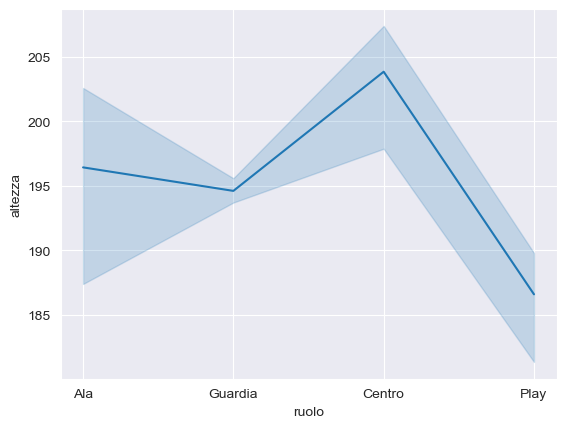

In [8]:
sns.lineplot(data=giocatori, x="ruolo", y="altezza")

Dal seguente grafico è possibili evincere che il ruolo dei giocatori è molto legato all'altezza dei giocatori

Suddivisione del set di dati in set di formazione e test
Abbiamo diviso i set di formazione e test con l'aiuto della funzione train_test_split()

In [9]:
x = giocatori.drop('ruolo', axis=1)
y = giocatori['ruolo']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1,random_state=100)

Questo codice implementa un classificatore K-Nearest Neighbors utilizzando la libreria scikit-learn. In particolare, viene utilizzato l'algoritmo di ricerca sulle griglie (GridSearchCV) per selezionare il valore ottimale di K.

La prima riga crea un'istanza del classificatore KNeighborsClassifier. Poi viene importata la classe GridSearchCV dalla libreria scikit-learn.

In seguito, viene definita una lista di valori compresi tra 1 e 31 per il parametro K. Questi valori verranno utilizzati come valori possibili per il parametro n_neighbors durante la ricerca sulla griglia.

La funzione di ricerca sulla griglia viene quindi creata specificando l'oggetto knn come modello, il dizionario param_grid con le opzioni per n_neighbors, e altri parametri come il numero di pieghe per la validazione incrociata (cv=10), la metrica di valutazione (scoring='accuracy') e la visualizzazione dei risultati di addestramento (return_train_score=False, verbose=1).

Infine, il modello viene addestrato utilizzando i dati di addestramento (x_train, y_train) e la funzione fit(). Il parametro K ottimale viene quindi selezionato come il miglior parametro n_neighbors dal risultato della ricerca sulle griglie.

L'accuratezza del modello addestrato viene quindi calcolata e stampata a schermo.


In [10]:
knn = KNeighborsClassifier()
from sklearn.model_selection import GridSearchCV
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)

# fitting the model for grid search
grid_search=grid.fit(x_train, y_train)
K= grid_search.best_params_['n_neighbors']
print('n_neighbors: '+ str(K))
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Fitting 10 folds for each of 30 candidates, totalling 300 fits
n_neighbors: 17
Accuracy for our training dataset with tuning is : 69.50%


Ora valutiamo il modello utilizzando i dati di test, a questo scopo abbiamo impostato una matrice di confusione per aiutarci a scoprire veri positivi, veri negativi, falsi positivi e falsi negativi.

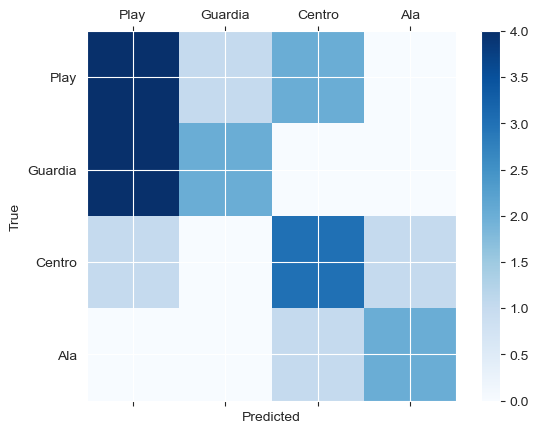

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(grid, X_train, y_train, values_format='d'):
    cm = confusion_matrix(y_train, grid.predict(X_train))
    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticks(range(len(set(y_train))))
    ax.set_yticks(range(len(set(y_train))))
    ax.set_xticklabels(list(set(y_train)))
    ax.set_yticklabels(list(set(y_train)))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(grid, x_test, y_test, values_format='d')

Dalle matrici di confusione è possibile notare che il modello è leggermente sbilanciato sul predire i giocatori con ruolo centro.